In [1]:
import polars as pl
import re
from typing import List, Tuple
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from tqdm import tqdm  # for progress bars
from sklearn.model_selection import GridSearchCV
from collections import Counter

# Plot histogram of word counts
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
# polars config
pl.Config.load_from_file("../polars_cfg.json")

# 1. Data loading

Choose whether to include participants that didn't complete all five tasks in the analyses with the True / False toggle.


In [3]:
# data file paths
data_path = "/Users/solimlegris/Projets/h-arc-osf/data/summary_data.csv"
df = pl.read_csv(data_path)
df.head()

exp_name,task_type,hashed_id,joint_id_task,task_name,task_number,attempt_number,num_actions,solved,test_output_grid,first_written_solution,last_written_solution,complete
str,str,str,str,str,i64,i64,i64,bool,str,str,str,bool
"""expv2""","""training""","""59e36641c3391529505bdf7af902cec0""","""59e36641c3391529505bdf7af902cec0_32597951.jso…","""32597951.json""",1,1,133,false,"""|10010010010010010|01001001001001001|00100100…","""YES DONE EASILY""","""INTERESTING TO COMPLETE""",true
"""expv2""","""training""","""59e36641c3391529505bdf7af902cec0""","""59e36641c3391529505bdf7af902cec0_32597951.jso…","""32597951.json""",1,2,151,false,"""|10010010010010010|01001001001001001|00100100…","""YES DONE EASILY""","""INTERESTING TO COMPLETE""",true
"""expv2""","""training""","""59e36641c3391529505bdf7af902cec0""","""59e36641c3391529505bdf7af902cec0_32597951.jso…","""32597951.json""",1,3,182,false,"""|10010010010010010|01001001001001001|00100100…","""YES DONE EASILY""","""INTERESTING TO COMPLETE""",true
"""expv2""","""training""","""59e36641c3391529505bdf7af902cec0""","""59e36641c3391529505bdf7af902cec0_321b1fc6.jso…","""321b1fc6.json""",2,1,43,false,"""|0000000000|0440004400|3433034330|0030000300|…","""SUPER EXPERIMENT KEEP COMPELETE THE TASK""","""INTERESTING TO COMPLE THE TASKS""",true
"""expv2""","""training""","""59e36641c3391529505bdf7af902cec0""","""59e36641c3391529505bdf7af902cec0_321b1fc6.jso…","""321b1fc6.json""",2,2,53,true,"""|0000000000|0440004400|3433034330|0030000300|…","""SUPER EXPERIMENT KEEP COMPELETE THE TASK""","""INTERESTING TO COMPLE THE TASKS""",true


In [4]:
df_last_attempt = df.select(
    pl.all()
    .top_k_by("attempt_number", k=1)
    .over("joint_id_task", mapping_strategy="explode")
)
df_last_attempt_correct = df_last_attempt.filter(pl.col("solved"))
df_last_attempt_correct.head()

exp_name,task_type,hashed_id,joint_id_task,task_name,task_number,attempt_number,num_actions,solved,test_output_grid,first_written_solution,last_written_solution,complete
str,str,str,str,str,i64,i64,i64,bool,str,str,str,bool
"""expv2""","""training""","""59e36641c3391529505bdf7af902cec0""","""59e36641c3391529505bdf7af902cec0_321b1fc6.jso…","""321b1fc6.json""",2,2,53,true,"""|0000000000|0440004400|3433034330|0030000300|…","""SUPER EXPERIMENT KEEP COMPELETE THE TASK""","""INTERESTING TO COMPLE THE TASKS""",true
"""expv2""","""training""","""59e36641c3391529505bdf7af902cec0""","""59e36641c3391529505bdf7af902cec0_2dee498d.jso…","""2dee498d.json""",4,1,27,true,"""|02044|22044|02220|11022|11020|""","""QUITE EASY TASK""","""QUITE EASY TASK""",true
"""expv2""","""training""","""59e36641c3391529505bdf7af902cec0""","""59e36641c3391529505bdf7af902cec0_2dd70a9a.jso…","""2dd70a9a.json""",5,3,86,true,"""|8888000008800|8000082233000|0800880003000|00…","""I THINK ITS EASY""","""WOW SUPER AM COMPLETE THE TASKS""",true
"""expv6_1""","""evaluation""","""1a60b90e2a9c90b100e915adfdf7907e""","""1a60b90e2a9c90b100e915adfdf7907e_4364c1c4.jso…","""4364c1c4.json""",1,3,77,true,"""|8888888888888|8188188888888|8111188888888|81…","""The top half of the block moved 1 space left …","""The top block of color moved one space left a…",true
"""expv6_1""","""evaluation""","""1a60b90e2a9c90b100e915adfdf7907e""","""1a60b90e2a9c90b100e915adfdf7907e_4c177718.jso…","""4c177718.json""",2,2,25,true,"""|000000000000000|000000000000000|080000000000…","""The dark blue block stays where it is and the…","""The dark blue block stays where it is and the…",true


In [5]:
df_last_attempt_correct_filtered = df_last_attempt_correct.filter(
    pl.col("last_written_solution").str.split(" ").list.len() > 2
)

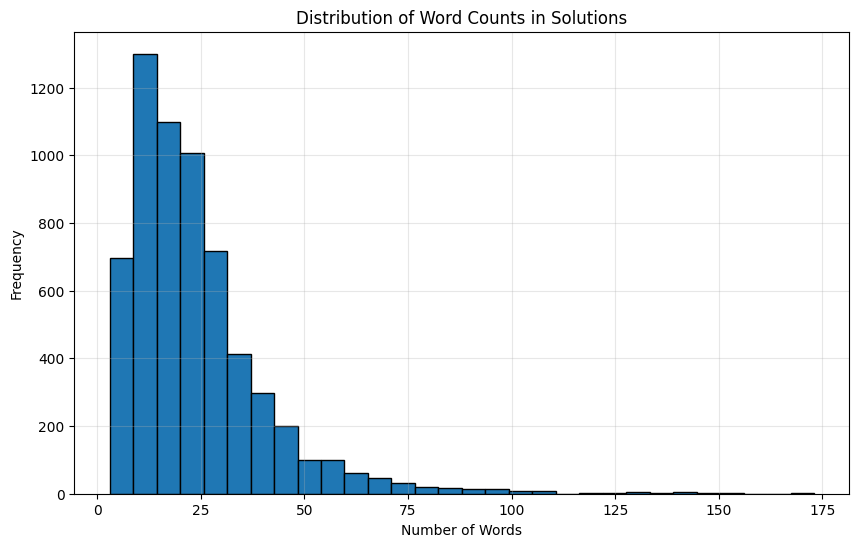

In [6]:
# Get word counts for each solution
word_counts = df_last_attempt_correct_filtered.select(
    pl.col("last_written_solution").str.split(" ").list.len().alias("word_count")
)


plt.figure(figsize=(10, 6))
plt.hist(word_counts["word_count"], bins=30, edgecolor="black")
plt.title("Distribution of Word Counts in Solutions")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
def analyze_vocabulary(texts: List[str], include_bigrams: bool = True):
    """
    Analyze the vocabulary in the text corpus.
    """

    # Create vectorizer to match our actual usage
    vectorizer = CountVectorizer(
        stop_words="english",
        ngram_range=(1, 2) if include_bigrams else (1, 1),
        max_features=None,  # No limit to see all words
    )

    # Fit to get all vocabulary
    vectorizer.fit(texts)
    vocab = vectorizer.get_feature_names_out()

    # Get document-term matrix
    doc_term_matrix = vectorizer.transform(texts)

    # Calculate word frequencies across all documents
    word_frequencies = np.asarray(doc_term_matrix.sum(axis=0)).flatten()

    # Create frequency distribution
    word_freq_dict = dict(zip(vocab, word_frequencies))

    # Split into unigrams and bigrams
    unigrams = {word: freq for word, freq in word_freq_dict.items() if " " not in word}
    bigrams = {word: freq for word, freq in word_freq_dict.items() if " " in word}

    print(f"Total vocabulary size: {len(vocab):,}")
    print(f"  - Unigrams (single words): {len(unigrams):,}")
    if include_bigrams:
        print(f"  - Bigrams (word pairs): {len(bigrams):,}")

    print(f"\nMost frequent unigrams:")
    for word, freq in sorted(unigrams.items(), key=lambda x: x[1], reverse=True)[:20]:
        print(f"  {word}: {freq}")

    if include_bigrams and bigrams:
        print(f"\nMost frequent bigrams:")
        for word, freq in sorted(bigrams.items(), key=lambda x: x[1], reverse=True)[
            :20
        ]:
            print(f"  {word}: {freq}")

    # Plot frequency distribution
    plt.figure(figsize=(12, 8))

    # Plot 1: Top words
    plt.subplot(2, 2, 1)
    top_words = sorted(unigrams.items(), key=lambda x: x[1], reverse=True)[:30]
    words, freqs = zip(*top_words)
    plt.barh(range(len(words)), freqs)
    plt.yticks(range(len(words)), words)
    plt.xlabel("Frequency")
    plt.title("Top 30 Most Frequent Words")
    plt.gca().invert_yaxis()

    # Plot 2: Frequency distribution (log scale)
    plt.subplot(2, 2, 2)
    all_freqs = sorted(word_frequencies, reverse=True)
    plt.loglog(range(1, len(all_freqs) + 1), all_freqs, "b-", alpha=0.8)
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.title("Word Frequency Distribution (Log-Log)")
    plt.grid(True, alpha=0.3)

    # Plot 3: Cumulative vocabulary coverage
    plt.subplot(2, 2, 3)
    cumulative_coverage = np.cumsum(all_freqs) / np.sum(all_freqs)
    vocab_sizes = range(1, len(all_freqs) + 1)
    plt.semilogx(vocab_sizes, cumulative_coverage, "r-", alpha=0.8)
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Cumulative Coverage")
    plt.title("Vocabulary Coverage")
    plt.grid(True, alpha=0.3)

    # Add some reference lines for common vocabulary sizes
    for size in [100, 500, 1000, 2000, 5000]:
        if size < len(all_freqs):
            coverage = cumulative_coverage[size - 1]
            plt.axvline(size, color="gray", alpha=0.5, linestyle="--")
            plt.text(
                size,
                coverage + 0.02,
                f"{size}\n({coverage:.1%})",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    # Plot 4: Distribution of word frequencies
    plt.subplot(2, 2, 4)
    plt.hist(word_frequencies, bins=50, edgecolor="black", alpha=0.7)
    plt.xlabel("Word Frequency")
    plt.ylabel("Number of Words")
    plt.title("Distribution of Word Frequencies")
    plt.yscale("log")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "total_vocab_size": len(vocab),
        "unigram_count": len(unigrams),
        "bigram_count": len(bigrams),
        "vocabulary": vocab,
        "word_frequencies": word_freq_dict,
        "coverage_at_sizes": {
            size: cumulative_coverage[size - 1] if size <= len(all_freqs) else 1.0
            for size in [100, 500, 1000, 2000, 5000, 10000]
        },
    }

In [8]:
def filter_uninformative_solutions(
    texts: List[str], min_words: int = 3, min_chars: int = 10
) -> Tuple[List[str], List[bool]]:
    """
    Filter out uninformative solutions using basic heuristics.
    Returns filtered texts and a mask of which texts were kept.
    """
    # Basic heuristics
    mask = []
    for text in texts:
        # Check length
        words = text.split()
        if len(words) < min_words or len(text) < min_chars:
            mask.append(False)
            continue

        # Check for common uninformative patterns
        uninformative_patterns = [
            r"^\s*$",  # Empty or whitespace only
            r"^[^a-zA-Z]*$",  # No letters
            r"^[^a-zA-Z0-9]*$",  # No alphanumeric
            r"^\s*[.,!?]+\s*$",  # Only punctuation
        ]

        if any(re.match(pattern, text) for pattern in uninformative_patterns):
            mask.append(False)
            continue

        mask.append(True)

    return [text for text, keep in zip(texts, mask) if keep], mask

In [9]:
texts = df_last_attempt_correct_filtered["last_written_solution"].to_list()
task_ids = df_last_attempt_correct_filtered["task_name"].to_list()

In [10]:
# Filter uninformative solutions
filtered_texts, mask = filter_uninformative_solutions(texts)
filtered_task_ids = [tid for tid, keep in zip(task_ids, mask) if keep]

print(f"Original texts: {len(texts)}")
print(f"Filtered texts: {len(filtered_texts)}")
print(f"Removed texts: {len(texts) - len(filtered_texts)}")

Original texts: 6169
Filtered texts: 6164
Removed texts: 5


In [11]:
# Count occurrences of each task_id
task_id_counts = Counter(filtered_task_ids)

# Filter out task_ids with less than 6 texts
valid_task_ids = {tid for tid, count in task_id_counts.items() if count >= 4}

# Filter texts and task_ids to keep only those with valid task_ids
filtered_texts = [
    text
    for text, tid in zip(filtered_texts, filtered_task_ids)
    if tid in valid_task_ids
]
filtered_task_ids = [tid for tid in filtered_task_ids if tid in valid_task_ids]

print(f"After filtering rare tasks:")
print(f"Remaining texts: {len(filtered_texts)}")
print(f"Remaining unique tasks: {len(valid_task_ids)}")

After filtering rare tasks:
Remaining texts: 5940
Remaining unique tasks: 691


Total vocabulary size: 2,777
  - Unigrams (single words): 2,777

Most frequent unigrams:
  color: 2340
  blue: 2230
  squares: 2176
  grid: 1733
  square: 1677
  input: 1671
  red: 1508
  pattern: 1181
  colors: 1054
  output: 1047
  black: 1039
  colored: 963
  green: 957
  shape: 848
  blocks: 777
  left: 725
  yellow: 724
  line: 720
  right: 699
  test: 651


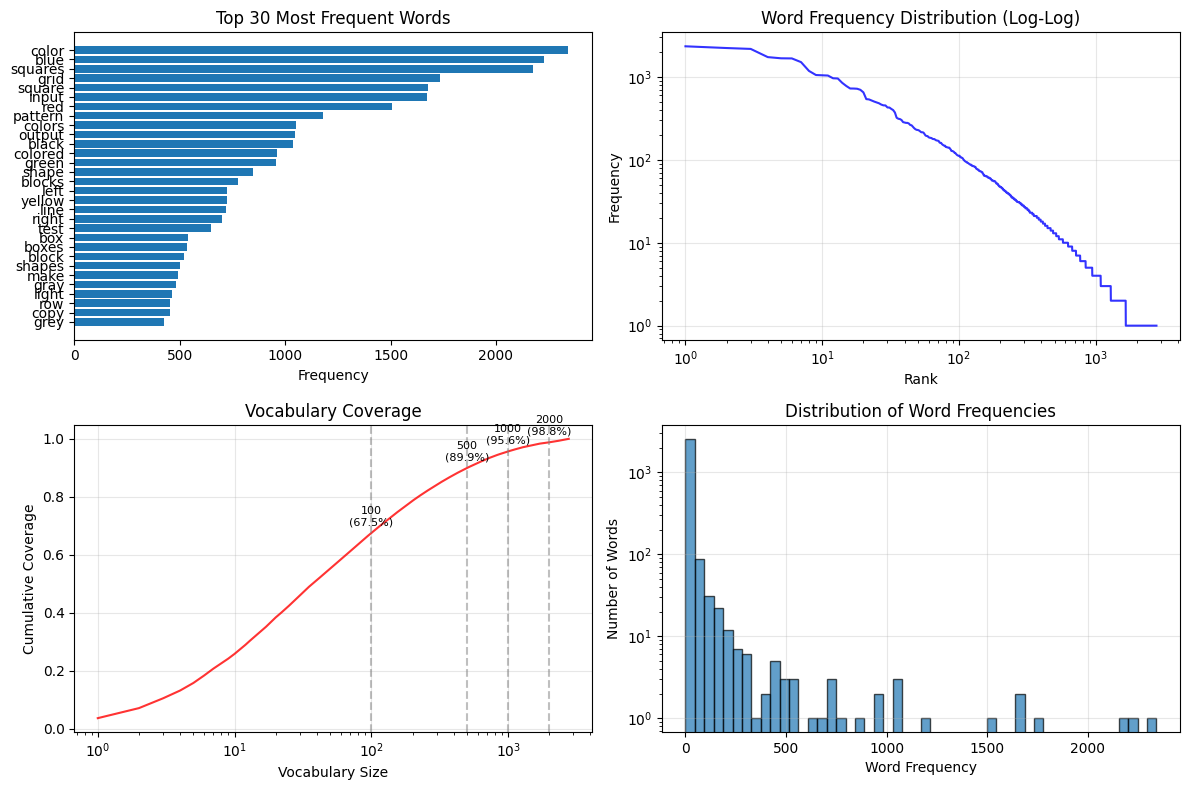

In [12]:
# Analyze vocabulary
vocab_analysis = analyze_vocabulary(filtered_texts, include_bigrams=False)

In [15]:
def optimize_vocabulary_size(texts, labels, max_features_range=None, alpha_range=None):
    """
    Find optimal vocabulary size using grid search with cross-validation.

    Args:
        texts: List of text descriptions
        labels: List of task IDs
        max_features_range: List of vocabulary sizes to try. If None, uses default range.
        alpha_range: List of smoothing values to try. If None, uses default range.
    """
    if max_features_range is None:
        # Based on your vocabulary analysis: 31,527 total features
        # Test different coverage levels
        max_features_range = [
            100,  # Very small - only most frequent words
            250,  # Small
            500,  #
            1000,  # Standard baseline
            2000,  # Most of vocabulary
            None,  # All 2777 features
        ]

    if alpha_range is None:
        # Common smoothing values to try
        alpha_range = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]

    # Create pipeline
    pipeline = Pipeline(
        [
            (
                "vectorizer",
                CountVectorizer(stop_words="english", ngram_range=(1, 1), binary=True),
            ),
            ("classifier", BernoulliNB()),
        ]
    )

    # Set up grid search parameters - now includes both vocab size and smoothing
    param_grid = {
        "vectorizer__max_features": max_features_range,
        "classifier__alpha": alpha_range,  # Laplacian smoothing parameter
    }

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,  # 5-fold cross-validation
        scoring="accuracy",
        n_jobs=-1,  # Use all available cores
        return_train_score=True,
    )

    print("Running grid search...")
    grid_search.fit(texts, labels)

    # Get results - fix the Polars casting issue
    import pandas as pd

    results_pandas = pd.DataFrame(grid_search.cv_results_)
    results = pl.from_pandas(results_pandas)

    # Print results
    print("\nResults Summary:")
    best_vocab = grid_search.best_params_.get("vectorizer__max_features")
    best_alpha = grid_search.best_params_.get("classifier__alpha", 1.0)

    if best_vocab is None:
        print(f"Best vocabulary size: All features")
    else:
        print(f"Best vocabulary size: {best_vocab:,}")
    print(f"Best smoothing parameter (alpha): {best_alpha}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")

    # Show top 10 parameter combinations
    print("\nTop 10 Parameter Combinations:")
    top_results = (
        results.select(
            [
                "param_vectorizer__max_features",
                "param_classifier__alpha",
                "mean_test_score",
                "std_test_score",
            ]
        )
        .with_columns(pl.col("param_vectorizer__max_features").fill_null("All"))
        .sort("mean_test_score", descending=True)
        .head(10)
    )

    print(top_results)

    return grid_search.best_params_, grid_search

Train+Val set size: 4158
Test set size: 1782

Optimizing vocabulary size and smoothing on train+val data only...
Running grid search...


/Users/solimlegris/Projets/h-arc/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(



Results Summary:
Best vocabulary size: 1,000
Best smoothing parameter (alpha): 0.01
Best cross-validation score: 0.209

Top 10 Parameter Combinations:
shape: (10, 4)
┌────────────────────────────────┬─────────────────────────┬─────────────────┬────────────────┐
│ param_vectorizer__max_features ┆ param_classifier__alpha ┆ mean_test_score ┆ std_test_score │
│ ---                            ┆ ---                     ┆ ---             ┆ ---            │
│ str                            ┆ f64                     ┆ f64             ┆ f64            │
╞════════════════════════════════╪═════════════════════════╪═════════════════╪════════════════╡
│ 1000                           ┆ 0.01                    ┆ 0.208991        ┆ 0.012445       │
│ 2000                           ┆ 0.01                    ┆ 0.203943        ┆ 0.014324       │
│ All                            ┆ 0.01                    ┆ 0.201778        ┆ 0.0141         │
│ 500                            ┆ 0.01                    ┆ 0.20

100%|██████████| 1000/1000 [00:27<00:00, 36.90it/s]



Final Evaluation Results:
Best vocabulary size: 1000
Best smoothing parameter (alpha): 0.01
Test set accuracy: 0.237
Chance level accuracy: 0.002 (±0.001)
P-value: 0.0000


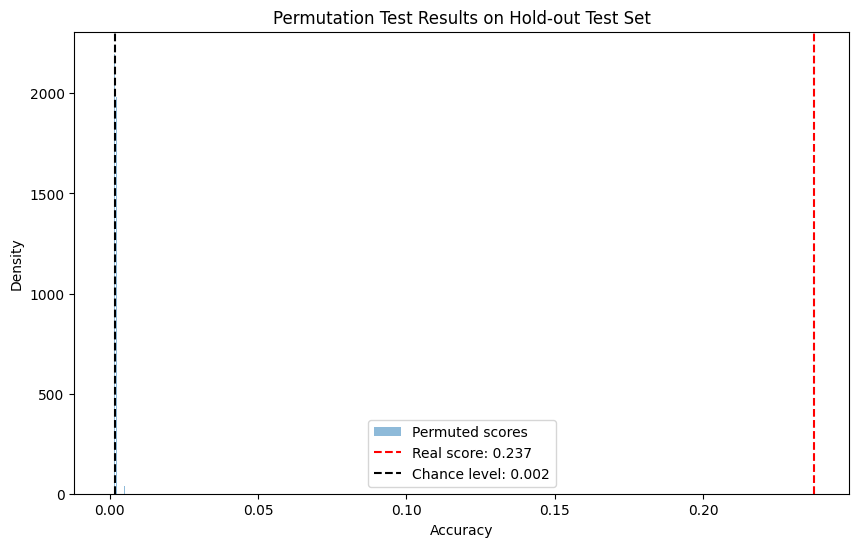

In [16]:
# First, create a proper train/test split

# Split into train+val and test (80/30)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    filtered_texts,
    filtered_task_ids,
    test_size=0.3,
    random_state=RANDOM_SEED,
    stratify=filtered_task_ids,
)

print(f"Train+Val set size: {len(X_train_val)}")
print(f"Test set size: {len(X_test)}")

# Now optimize vocabulary size and smoothing using only train+val data
print("\nOptimizing vocabulary size and smoothing on train+val data only...")
best_params, grid_search = optimize_vocabulary_size(X_train_val, y_train_val)


# Function for final evaluation with permutation test
def evaluate_final_performance(X_test, y_test, best_params, n_permutations=1000):
    """
    Evaluate final performance on held-out test set with permutation testing.
    """
    # Extract best parameters
    best_vocab_size = best_params["vectorizer__max_features"]
    best_alpha = best_params["classifier__alpha"]

    # Create pipeline with best parameters
    pipeline = Pipeline(
        [
            (
                "vectorizer",
                CountVectorizer(
                    max_features=best_vocab_size,
                    stop_words="english",
                    ngram_range=(1, 1),
                    binary=True,
                ),
            ),
            ("classifier", BernoulliNB(alpha=best_alpha)),
        ]
    )

    # Fit on all train+val data
    pipeline.fit(X_train_val, y_train_val)

    # Get real score on test set
    real_score = pipeline.score(X_test, y_test)

    # Permutation testing
    permutation_scores = []
    print("Running permutation tests...")

    for _ in tqdm(range(n_permutations)):
        # Shuffle test labels
        shuffled_labels = np.random.permutation(y_test)
        # Score with shuffled labels
        perm_score = pipeline.score(X_test, shuffled_labels)
        permutation_scores.append(perm_score)

    permutation_scores = np.array(permutation_scores)
    p_value = np.mean(permutation_scores >= real_score)

    # Print results
    print("\nFinal Evaluation Results:")
    print(f"Best vocabulary size: {best_vocab_size}")
    print(f"Best smoothing parameter (alpha): {best_alpha}")
    print(f"Test set accuracy: {real_score:.3f}")
    print(
        f"Chance level accuracy: {np.mean(permutation_scores):.3f} (±{np.std(permutation_scores):.3f})"
    )
    print(f"P-value: {p_value:.4f}")

    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.hist(
        permutation_scores, bins=50, density=True, alpha=0.5, label="Permuted scores"
    )
    plt.axvline(
        real_score, color="red", linestyle="--", label=f"Real score: {real_score:.3f}"
    )
    plt.axvline(
        np.mean(permutation_scores),
        color="black",
        linestyle="--",
        label=f"Chance level: {np.mean(permutation_scores):.3f}",
    )
    plt.xlabel("Accuracy")
    plt.ylabel("Density")
    plt.title("Permutation Test Results on Hold-out Test Set")
    plt.legend()
    plt.show()

    return {
        "test_score": real_score,
        "permutation_scores": permutation_scores,
        "p_value": p_value,
    }


# Run final evaluation
print("\nRunning final evaluation on held-out test set...")
final_results = evaluate_final_performance(X_test, y_test, best_params)